In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Common Functions
You are not expected to modify these
"""
_bits = []
for i in range(256):
    bs = bin(i)[2:].rjust(8,'0')
    _bits.append(np.array([float(v) for v in bs]))

def read_img(path):
    """Read image."""
    image = cv2.imread(path, cv2.COLOR_BGR2RGB)
    return image

def save_img(img, path):
    """Save image."""
    cv2.imwrite(path, img)

# note this is different than in previous homeworks
def show_img(image, *args, **kwargs):
    if len(image.shape) == 2:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

def homography_transform(X, H):
    '''
    Perform homography transformation on a set of points X
    using homography matrix H

    Input - X: a set of 2D points in an array with size (N,2)
            H: a 3*3 homography matrix
    Output -Y: a set of 2D points in an array with size (N,2)
    '''
    X_homogeneous = np.hstack([X,np.ones((X.shape[0],1))])
    Y = np.dot(H,X_homogeneous.T).T
    return Y[:,:2] / Y[:,2][:,None]

def get_match_points(kp1, kp2, matches):
    '''
    Returns list of paired keypoint locations

    Input - kp1: Keypoint matrix 1 of shape (N,4)
            kp2: Keypoint matrix 1 of shape (M,4)
            matches: List of matching pairs indices between the 2 sets of keypoints (K,2)

    Output - An array of shape (K,4) where row i contains pixel locations corresponding
             to a matched keypoint in the 2 images : [img1_x, img1_y, img2_x, img2_y]
    '''
    return np.hstack([kp1[matches[:,0],:2], kp2[matches[:,1],:2]])

def kps_to_matrix(kps):
    '''
    Converts cv2 container of keypoint locations into numpy array

    Input - kps: opencv container of keypoints location

    Output - K: A numpy Keypoint matrix of shape (N,4)
    '''
    K = np.zeros((len(kps),4))
    for i in range(len(kps)):
        K[i,:2] = kps[i].pt
        K[i,2] = kps[i].angle
        K[i,3] = kps[i].octave
    return K

def expand_binarize(desc):
    '''
    Explicitly expand packed binary keypoint descriptors like AKAZE and ORB.
    You do not need to modify or worry about this.

    AKAZE and ORB return a descriptor that is binary. Usually one compares
    descriptors using the hamming distance (# of bits that differ). This is
    usually fast since one can do this with binary operators. On Intel
    processors, there's an instruction for this: popcnt/population count.

    On the other hand, this prevents you from actually implementing all the steps
    of the pipeline and requires you writing a hamming distance. So instead, we
    explicitly expand the feature from F packed binary uint8s to (8F) explicit
    binary 0 or 1 descriptors. The square of the L2 distance of these
    descriptors is the hamming distance.

    Converts a matrix where each row is a vector containing F uint8s into their
    explicit binary form.

    Input - desc: matrix of size (N,F) containing N 8F dimensional binary
                  descriptors packed into N, F dimensional uint8s

    Output - binary_desc: matrix of size (N,8F) containing only 0s or 1s that
                          expands this to be explicit
    '''
    N, F = desc.shape
    binary_desc = np.zeros((N,F*8))
    for i in range(N):
        for j in range(F):
            binary_desc[i,(j*8):((j+1)*8)] = _bits[desc[i,j]]
    return binary_desc

def get_AKAZE(I):
    '''
    Extracts AKAZE keypoints and descriptors from an image

    Input - img: Input image of shape (H,W,3)

    Output - kps: (K,4) matrix where each row is [x,y,angle,octave]
             desc: (K,1024) matrix of AKAZE descriptors expanded to be
                   comparable using squared L2 distance
    '''
    akaze = cv2.AKAZE_create()
    kps, D = akaze.detectAndCompute(I, None)
    return kps_to_matrix(kps), expand_binarize(D).astype(np.float32)



In [3]:
def fit_homography(XY):
    '''
    Given a set of N correspondences XY of the form [x,y,x',y'],
    fit a homography from [x,y,1] to [x',y',1].

    Input - XY: an array with size(N,4), each row contains two
            points in the form [x_i, y_i, x'_i, y'_i] (1,4)
    Output - H: a (3,3) homography matrix that satisfies [x',y',1]^T === H [x,y,1]^T
    '''
    A = []
    for x, y, x_prime, y_prime in XY:
        # Define p and p_prime
        p = np.array([x, y, 1])
        # Construct two rows for each correspondence
        row1 = np.hstack([np.zeros(3), -p, y_prime * p])
        row2 = np.hstack([p, np.zeros(3), -x_prime * p])
        A.append(row1)
        A.append(row2)
    A = np.vstack(A)

    # Compute SVD of A
    _, _, Vt = np.linalg.svd(A)
    # The solution is the eigenvector corresponding to the smallest eigenvalue
    H = Vt[-1].reshape(3, 3)
    # Normalize H so that H[2, 2] = 1
    if H[2, 2] != 0:
        H = H / H[2, 2]
    return H



In [4]:
import numpy as np

def RANSAC_fit_homography(XY, eps=1, nIters=1000):
    '''
    Perform RANSAC to find the homography transformation
    matrix which has the most inliers.

    Input:
        XY: an array with size (N,4), each row contains two points
            in the form [x_i, y_i, x'_i, y'_i].
        eps: threshold distance for inlier calculation.
        nIters: number of iterations for running RANSAC.

    Output:
        bestRefit: a (3,3) homography matrix fit to the inliers from
                   the best model.
    '''

    # Initialize best homography, best inlier count, and inliers array
    bestH, bestCount, bestInliers = np.eye(3), -1, np.zeros(XY.shape[0])
    bestRefit = np.eye(3)

    for _ in range(nIters):
        # Randomly sample 4 points without replacement
        sample_idx = np.random.choice(XY.shape[0], 4, replace=False)
        sample_points = XY[sample_idx]

        # Compute the homography for the sample points
        H = compute_homography(sample_points)  # Helper function to compute H

        # Compute inliers by transforming points with H and calculating distances
        transformed_pts = apply_homography(XY[:, :2], H)  # Transform input points
        distances = np.linalg.norm(transformed_pts - XY[:, 2:], axis=1)

        # Find inliers within the threshold distance
        inliers = distances < eps
        inlier_count = np.sum(inliers)

        # Check if this model is the best so far
        if inlier_count > bestCount:
            bestCount = inlier_count
            bestH = H
            bestInliers = inliers

    # Refit homography using all inliers from the best model
    bestRefit = compute_homography(XY[bestInliers])  # Final fitting with best inliers

    return bestRefit

# Helper functions for computing homography and applying it to points
def compute_homography(points):
    # Implement the homography matrix computation based on provided points
    pass

def apply_homography(points, H):
    # Apply homography transformation to given points
    pass


In [5]:
import numpy as np

def bilinear(image, row, col):
    """
    Return the interpolated value for a fractional row, col position in the image.
    Assumes row and col are non-negative and less than the height and width of the image - 1.

    Input:
        image: H x W (2D numpy array representing grayscale image)
        row, col: floating point scalar for row and column position

    Output:
        value: scalar representing the interpolated intensity value
    """
    # Get the integer part and fractional part of the row and col
    row_floor, col_floor = int(np.floor(row)), int(np.floor(col))
    row_ceil, col_ceil = min(row_floor + 1, image.shape[0] - 1), min(col_floor + 1, image.shape[1] - 1)

    # Calculate distances of the fractional point to the surrounding integer grid points
    delta_r, delta_c = row - row_floor, col - col_floor

    # Compute bilinear interpolation
    top_left = image[row_floor, col_floor]
    top_right = image[row_floor, col_ceil]
    bottom_left = image[row_ceil, col_floor]
    bottom_right = image[row_ceil, col_ceil]

    # Interpolating along row
    top = (1 - delta_c) * top_left + delta_c * top_right
    bottom = (1 - delta_c) * bottom_left + delta_c * bottom_right

    # Interpolating along column
    value = (1 - delta_r) * top + delta_r * bottom

    return value


In [6]:
import numpy as np

def compute_distance(desc1, desc2):
    '''
    Calculates L2 distance between 2 binary descriptor vectors.

    Input:
        desc1: Descriptor vector of shape (N, F)
        desc2: Descriptor vector of shape (M, F)

    Output:
        dist: a (N, M) L2 distance matrix where dist(i, j)
              is the squared Euclidean distance between row i of
              desc1 and desc2.
    '''
    # Compute the squared norms of each row in desc1 and desc2
    desc1_norm = np.sum(desc1 ** 2, axis=1).reshape(-1, 1)  # Shape (N, 1)
    desc2_norm = np.sum(desc2 ** 2, axis=1).reshape(1, -1)  # Shape (1, M)

    # Calculate the squared Euclidean distance using the formula
    dist = desc1_norm + desc2_norm - 2 * np.dot(desc1, desc2.T)

    return dist


In [7]:
import numpy as np

def find_matches(desc1, desc2, ratioThreshold):
    '''
    Calculates the matches between two sets of keypoint descriptors based
    on distance and ratio test.

    Input:
        desc1: Descriptor vector of shape (N, F)
        desc2: Descriptor vector of shape (M, F)
        ratioThreshold: Maximum acceptable distance ratio between the
                        nearest and second-nearest matches

    Output:
        matches: a list of tuples (i, j) where each tuple represents
                 a match between desc1[i] and desc2[j]
    '''
    # Compute the squared Euclidean distance matrix
    dist = compute_distance(desc1, desc2)  # Shape (N, M)

    # Iterate over each descriptor in desc1 to find matches
    for i in range(dist.shape[0]):
        # Sort distances for descriptor i and get indices of nearest neighbors
        sorted_indices = np.argsort(dist[i])
        nearest, second_nearest = sorted_indices[:2]

        # Calculate the distance ratio
        ratio = dist[i, nearest] / dist[i, second_nearest] if dist[i, second_nearest] != 0 else float('inf')

        # Apply the ratio test
        if ratio < ratioThreshold:
            matches.append((i, nearest))

    return matches


In [8]:
import cv2
import numpy as np

def draw_matches(img1, img2, kp1, kp2, matches):
    '''
    Creates an output image where the two source images are stacked vertically,
    connecting matching keypoints with lines.

    Input:
        img1: Input image 1 of shape (H1, W1, 3)
        img2: Input image 2 of shape (H2, W2, 3)
        kp1: Keypoint matrix for image 1 of shape (N, 4)
        kp2: Keypoint matrix for image 2 of shape (M, 4)
        matches: List of matching pairs indices between the 2 sets of keypoints (K, 2)

    Output:
        output: Image where img1 and img2 are stacked vertically, with lines
                joining the matched keypoints.
    '''

    # Stack the images vertically
    H1, W1, _ = img1.shape
    H2, W2, _ = img2.shape
    output = np.zeros((H1 + H2, max(W1, W2), 3), dtype=img1.dtype)
    output[:H1, :W1] = img1
    output[H1:H1 + H2, :W2] = img2

    # Draw lines for each matched keypoint pair
    for i, j in matches:
        # Get the coordinates of the matched keypoints
        x1, y1 = int(kp1[i, 0]), int(kp1[i, 1])
        x2, y2 = int(kp2[j, 0]), int(kp2[j, 1]) + H1  # Offset y2 by the height of img1

        # Generate a random color for the line
        color = tuple(np.random.randint(0, 256, 3).tolist())  # Random color in RGB

        # Draw the line connecting the matched keypoints
        cv2.line(output, (x1, y1), (x2, y2), color, 1)

    return output


In [9]:
import numpy as np
import cv2

def warp_and_combine(img1, img2, H):
    '''
    Merges the two images together given the two images and a homography:
    once you have the homography you do not need the correspondences anymore.

    Input - img1: Input image 1 of shape (H1, W1, 3)
            img2: Input image 2 of shape (H2, W2, 3)
            H: homography mapping from img1 to img2
    Output - V: stitched image of size (?, ?, 3)
    '''

    # Get the size of the images
    H1, W1 = img1.shape[:2]
    H2, W2 = img2.shape[:2]

    # Define the corners of img1 (the four corners)
    corners_img1 = np.array([[0, 0], [W1, 0], [W1, H1], [0, H1]], dtype='float32')
    # Apply the homography to these corners to get the new positions of img1
    corners_img1_transformed = cv2.perspectiveTransform(corners_img1[None, :, :], H)[0]

    # Find the bounding box for the combined image size
    min_x = min(corners_img1_transformed[:, 0].min(), 0)
    max_x = max(corners_img1_transformed[:, 0].max(), W2)
    min_y = min(corners_img1_transformed[:, 1].min(), 0)
    max_y = max(corners_img1_transformed[:, 1].max(), H2)

    # Calculate the size of the output image
    new_width = int(max_x - min_x)
    new_height = int(max_y - min_y)

    # Define the transformation matrix to adjust the origin of the warped image
    translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y]], dtype='float32')

    # Warp img1 using the homography and translation to the new canvas
    warped_img1 = cv2.warpPerspective(img1, translation_matrix.dot(H), (new_width, new_height))

    # Place img2 into the resulting image (at its original position)
    V = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    V[-min_y:H2-min_y, -min_x:W2-min_x] = img2

    # Blend the images: Here we directly overlay the warped img1 on top of img2
    # Mask for img1
    mask_img1 = (warped_img1 > 0)
    V[mask_img1] = warped_img1[mask_img1]

    return V


In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
rootpath = '/content/gdrive/MyDrive/cs558_resources/hw3/stitch'

# Load images
import os
import cv2

def read_img(path):
    return cv2.imread(path)

to_stitch = 'vgg'
I1 = read_img(os.path.join(rootpath, to_stitch, 'p1.jpg'))
I2 = read_img(os.path.join(rootpath, to_stitch, 'p2.jpg'))


Mounted at /content/gdrive


Mounted at /content/gdrive


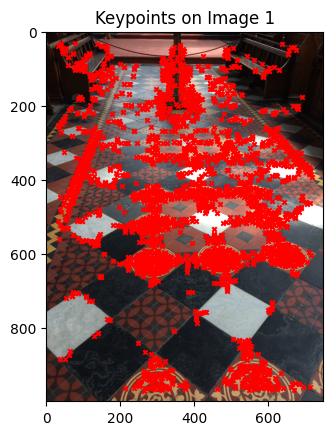

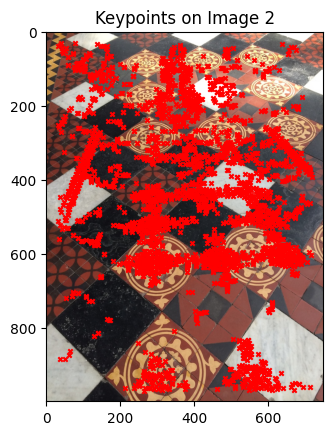

In [11]:
from google.colab import drive
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)
rootpath = '/content/gdrive/MyDrive/Colab Notebooks/hw3/stitch/mertonchapel'

# Load images
def read_img(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image at path '{path}' not found.")
    return img

to_stitch = 'vgg'
I1_path = os.path.join(rootpath, to_stitch, '/content/gdrive/MyDrive/Colab Notebooks/hw3/stitch/mertonchapel/p1.jpg')
I2_path = os.path.join(rootpath, to_stitch, '/content/gdrive/MyDrive/Colab Notebooks/hw3/stitch/mertonchapel/p2.jpg')
I1 = read_img(I1_path)
I2 = read_img(I2_path)

# Check if images are loaded correctly
if I1 is None or I2 is None:
    print("One of the images didn't load. Check the paths and image files.")
else:
    # Step 1: Extract keypoints and descriptors using AKAZE
    akaze = cv2.AKAZE_create()
    keypoints1, descriptors1 = akaze.detectAndCompute(I1, None)
    keypoints2, descriptors2 = akaze.detectAndCompute(I2, None)

    # Convert keypoints to numpy array format for plotting
    keypoints1_coords = np.array([kp.pt for kp in keypoints1])  # (x, y) coordinates

    # Visualize keypoints on one of the images
    plt.imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))
    plt.scatter(keypoints1_coords[:, 0], keypoints1_coords[:, 1], s=10, c='r', marker='x')
    plt.title("Keypoints on Image 1")
    plt.show()

    # Visualize keypoints on one of the images
    plt.imshow(cv2.cvtColor(I2, cv2.COLOR_BGR2RGB))
    plt.scatter(keypoints1_coords[:, 0], keypoints1_coords[:, 1], s=10, c='r', marker='x')
    plt.title("Keypoints on Image 2")
    plt.show()



In [12]:
import numpy as np

def find_matches(desc1, desc2, ratioThreshold):
    '''
    Calculates the matches between two sets of keypoint descriptors based
    on distance and ratio test.

    Input:
        desc1: Descriptor vector of shape (N, F)
        desc2: Descriptor vector of shape (M, F)
        ratioThreshold: Maximum acceptable distance ratio between the
                        nearest and second-nearest matches

    Output:
        matches: a list of tuples (i, j) where each tuple represents
                 a match between desc1[i] and desc2[j]
    '''
    # Initialize matches list
    matches = []

    # Compute the squared Euclidean distance matrix
    dist = compute_distance(desc1, desc2)  # Shape (N, M)

    # Iterate over each descriptor in desc1 to find matches
    for i in range(dist.shape[0]):
        # Sort distances for descriptor i and get indices of nearest neighbors
        sorted_indices = np.argsort(dist[i])
        nearest, second_nearest = sorted_indices[:2]

        # Calculate the distance ratio
        ratio = dist[i, nearest] / dist[i, second_nearest] if dist[i, second_nearest] != 0 else float('inf')

        # Apply the ratio test
        if ratio < ratioThreshold:
            matches.append((i, nearest))

    return matches


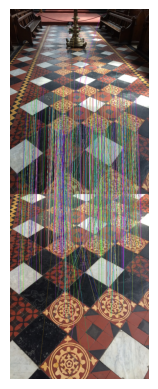

In [13]:
def RANSAC_fit_homography(XY, eps=1, nIters=1000):
    bestH, best_inliers = None, 0
    for _ in range(nIters):
        sample = XY[np.random.choice(XY.shape[0], 4, replace=False)]
        H = fit_homography(sample)

        transformed = homography_transform(XY[:, :2], H)
        distances = np.linalg.norm(transformed - XY[:, 2:], axis=1)
        inliers = np.sum(distances < eps)

        if inliers > best_inliers:
            best_inliers = inliers
            bestH = H

    inlier_points = XY[distances < eps]
    return fit_homography(inlier_points)

def homography_transform(X, H):
    X_homogeneous = np.hstack([X, np.ones((X.shape[0], 1))])
    Y = np.dot(H, X_homogeneous.T).T
    return Y[:, :2] / Y[:, 2][:, None]

def warp_and_combine(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners = np.array([[0, 0], [0, h2], [w2, h2], [w2, 0]], dtype=np.float32)
    warped_corners = homography_transform(corners, H)

    min_x = min(0, warped_corners[:, 0].min())
    min_y = min(0, warped_corners[:, 1].min())
    max_x = max(w1, warped_corners[:, 0].max())
    max_y = max(h1, warped_corners[:, 1].max())

    translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    canvas_w = int(max_x - min_x)
    canvas_h = int(max_y - min_y)

    img1_canvas = cv2.warpPerspective(img1, translation @ np.eye(3), (canvas_w, canvas_h))
    img2_canvas = cv2.warpPerspective(img2, translation @ H, (canvas_w, canvas_h))
    img1_canvas[img2_canvas > 0] = img2_canvas[img2_canvas > 0]

    return img1_canvas

# Load images
rootpath = '/content/gdrive/MyDrive/Colab Notebooks/hw3/stitch/mertonchapel'
to_stitch = 'mertonchapel'
I1 = read_img(os.path.join(rootpath, to_stitch, '/content/gdrive/MyDrive/Colab Notebooks/hw3/stitch/mertonchapel/p1.jpg'))
I2 = read_img(os.path.join(rootpath, to_stitch, '/content/gdrive/MyDrive/Colab Notebooks/hw3/stitch/mertonchapel/p2.jpg'))

# Step 1: Obtain keypoints and descriptors
kps1, desc1 = get_AKAZE(I1)
kps2, desc2 = get_AKAZE(I2)

# Step 2: Detect matches
dist_matrix = compute_distance(desc1, desc2)
matches = find_matches(desc1, desc2, ratioThreshold=0.75)
output_img = draw_matches(I1, I2, kps1, kps2, matches)
show_img(output_img)


# Step 3: RANSAC for homography fitting
matched_points = get_match_points(kps1, kps2, np.array(matches))
bestH = RANSAC_fit_homography(matched_points, eps=5, nIters=1000)



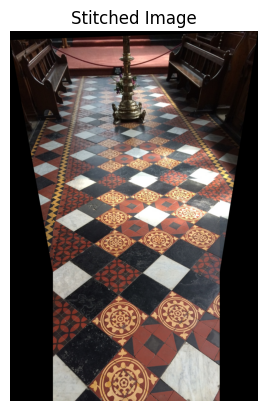

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def warp_and_stitch(img1, img2, H):
    '''
    Stitch two images using the homography H that maps img1 to img2's coordinate space.

    Input:
        img1, img2: Images to be stitched.
        H: Homography matrix that aligns img1 to img2.

    Output:
        stitched_image: The final stitched image that includes all pixels of both images.
    '''
    # Dimensions of both images
    H1, W1 = img1.shape[:2]
    H2, W2 = img2.shape[:2]

    # Define the four corners of img1 and transform them using the homography
    corners_img1 = np.array([[0, 0], [W1, 0], [W1, H1], [0, H1]], dtype=np.float32).reshape(-1, 1, 2)
    transformed_corners_img1 = cv2.perspectiveTransform(corners_img1, H)

    # Include img2's corners in the calculation of canvas boundaries
    corners_img2 = np.array([[0, 0], [W2, 0], [W2, H2], [0, H2]], dtype=np.float32).reshape(-1, 1, 2)
    all_corners = np.vstack((transformed_corners_img1, corners_img2))

    # Calculate canvas boundaries to contain both images
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # Calculate the translation matrix
    translation = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

    # Warp img1 onto the canvas
    canvas_width = x_max - x_min
    canvas_height = y_max - y_min
    warped_img1 = cv2.warpPerspective(img1, H_translation @ H, (canvas_width, canvas_height))

    # Initialize stitched_image with warped_img1 content and then overlay img2
    stitched_image = warped_img1.copy()
    stitched_image[translation[1]:H2 + translation[1], translation[0]:W2 + translation[0]] = img2

    return stitched_image

# Apply stitching
stitched_image = warp_and_stitch(I1, I2, bestH)

# Display the final stitched image
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.title("Stitched Image")
plt.axis('off')
plt.show()
